# GNO vs MGN (based on UAI1_full_resolution.py)


In [1]:
!nvidia-smi

Sun Oct 15 16:25:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   36C    P0              57W / 400W |      4MiB / 40960MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import numpy as np
import os
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from utilities import *
from nn_conv import NNConv_old

from timeit import default_timer

# Preprocessing the Dataset

GNO involves constructing graphs from the simulation results. As GNO performs integration on a prescribed ball with defined radius r, the connecitivity of node pair will be found by using the functions given in utilities

In [3]:
root_dir = os.getcwd()
print(root_dir)
#dataset_dir = os.path.join(root_dir, 'datasets')

#data_dir = '/data/gpfs/Projects/CSE_HPML/GNN+flow/00_dataset'
#dataset_dir = os.path.join(root_dir, 'datasets')

TRAIN_NAME = 'piececonst_r241_N1024_smooth1.mat'
TEST_NAME = 'piececonst_r241_N1024_smooth2.mat'

dataset_dir = os.path.join(root_dir, 'datasets')
if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

train_data_path = os.path.join(dataset_dir, TRAIN_NAME)
test_data_path = os.path.join(dataset_dir, TEST_NAME)
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')
modelsummary_dir = os.path.join(root_dir, 'model_details')

/scratch/users/ju1/01_nvidia_research/01_ccs_project/01_gno/01_test


## Input parameters

In [ ]:
r = 4 # radius of the stencil
s = int(((241 - 1)/r) + 1) # number of points on the grid
n = s**2 # number of nodes in the graph
m = 100 # number of training examples
k = 1 # number of features per node

radius_train = 0.1 # radius of training data
radius_test = 0.1 # radius of test data

print('resolution', s)
print('number of nodes', n)

ntrain = 100 # number of training examples
ntest = 40  # number of test examples

batch_size = 1
batch_size2 = 2
width = 64
ker_width = 1024
depth = 6
edge_features = 6
node_features = 6

epochs = 200
learning_rate = 0.0001
scheduler_step = 50
scheduler_gamma = 0.8

path = 'UAI1_r'+str(s)+'_n'+ str(ntrain)
path_model = 'model/'+path+''
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path+''
path_train_err = 'results/'+path+'train'
path_test_err16 = 'results/'+path+'test16'
path_test_err31 = 'results/'+path+'test31'
path_test_err61 = 'results/'+path+'test61'
path_image_train = 'image/'+path+'train'
path_image_test16 = 'image/'+path+'test16'
path_image_test31 = 'image/'+path+'test31'
path_image_test61 = 'image/'+path+'test61'


In [36]:
## hyper-parameter
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model': 'gno',  
         'data_type': 'darcy',
         'width': width,
         'ker_width': ker_width, 
         'depth': depth,
         'batch_size': 1,
         'edge_feature': edge_features,
         'node_feature': node_features,
         'epochs': 200, 
         'learning_rate': 1e-4,
         'weight_decay': 5e-4,
         'scheduler_step': 50,
         'scheduler_gamma': 0.8,
         'checkpoint_dir': './best_models/',
          'modelsummary_dir': './model_details/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
np.random.seed(5)     #NumPy

## Graph reconstruction

In [5]:

t1 = default_timer()

reader = MatReader(train_data_path)
train_a = reader.read_field('coeff')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_smooth = reader.read_field('Kcoeff')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_gradx = reader.read_field('Kcoeff_x')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_grady = reader.read_field('Kcoeff_y')[:ntrain,::r,::r].reshape(ntrain,-1)
train_u = reader.read_field('sol')[:ntrain,::r,::r].reshape(ntrain,-1)
train_u64 = reader.read_field('sol')[:ntrain,::r,::r].reshape(ntrain,-1)

reader.load_file(test_data_path)
test_a = reader.read_field('coeff')[:ntest,::4,::4].reshape(ntest,-1)
test_a_smooth = reader.read_field('Kcoeff')[:ntest,::4,::4].reshape(ntest,-1)
test_a_gradx = reader.read_field('Kcoeff_x')[:ntest,::4,::4].reshape(ntest,-1)
test_a_grady = reader.read_field('Kcoeff_y')[:ntest,::4,::4].reshape(ntest,-1)
test_u = reader.read_field('sol')[:ntest,::4,::4].reshape(ntest,-1)


a_normalizer = GaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)
as_normalizer = GaussianNormalizer(train_a_smooth)
train_a_smooth = as_normalizer.encode(train_a_smooth)
test_a_smooth = as_normalizer.encode(test_a_smooth)
agx_normalizer = GaussianNormalizer(train_a_gradx)
train_a_gradx = agx_normalizer.encode(train_a_gradx)
test_a_gradx = agx_normalizer.encode(test_a_gradx)
agy_normalizer = GaussianNormalizer(train_a_grady)
train_a_grady = agy_normalizer.encode(train_a_grady)
test_a_grady = agy_normalizer.encode(test_a_grady)


test_a = test_a.reshape(ntest,61,61)
test_a_smooth = test_a_smooth.reshape(ntest,61,61)
test_a_gradx = test_a_gradx.reshape(ntest,61,61)
test_a_grady = test_a_grady.reshape(ntest,61,61)
test_u = test_u.reshape(ntest,61,61)

test_a16 =test_a[:ntest,::4,::4].reshape(ntest,-1)
test_a_smooth16 = test_a_smooth[:ntest,::4,::4].reshape(ntest,-1)
test_a_gradx16 = test_a_gradx[:ntest,::4,::4].reshape(ntest,-1)
test_a_grady16 = test_a_grady[:ntest,::4,::4].reshape(ntest,-1)
test_u16 = test_u[:ntest,::4,::4].reshape(ntest,-1)
test_a31 =test_a[:ntest,::2,::2].reshape(ntest,-1)
test_a_smooth31 = test_a_smooth[:ntest,::2,::2].reshape(ntest,-1)
test_a_gradx31 = test_a_gradx[:ntest,::2,::2].reshape(ntest,-1)
test_a_grady31 = test_a_grady[:ntest,::2,::2].reshape(ntest,-1)
test_u31 = test_u[:ntest,::2,::2].reshape(ntest,-1)
test_a =test_a.reshape(ntest,-1)
test_a_smooth = test_a_smooth.reshape(ntest,-1)
test_a_gradx = test_a_gradx.reshape(ntest,-1)
test_a_grady = test_a_grady.reshape(ntest,-1)
test_u = test_u.reshape(ntest,-1)


u_normalizer = GaussianNormalizer(train_u)
train_u = u_normalizer.encode(train_u)
# test_u = y_normalizer.encode(test_u)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[s,s])
edge_index = meshgenerator.ball_connectivity(radius_train)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)

data_train = []
for j in range(ntrain):
    edge_attr = meshgenerator.attributes(theta=train_a[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=train_u[j,:])
    data_train.append(Data(x=torch.cat([grid, train_a[j,:].reshape(-1, 1),
                                        train_a_smooth[j,:].reshape(-1, 1), train_a_gradx[j,:].reshape(-1, 1), train_a_grady[j,:].reshape(-1, 1)
                                        ], dim=1),
                           y=train_u[j,:], coeff=train_a[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary= edge_attr_boundary
                           ))

print('train grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[16,16])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test16 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a16[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test16.append(Data(x=torch.cat([grid, test_a16[j,:].reshape(-1, 1),
                                       test_a_smooth16[j,:].reshape(-1, 1), test_a_gradx16[j,:].reshape(-1, 1), test_a_grady16[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u16[j, :], coeff=test_a16[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('16 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[31,31])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test31 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a31[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test31.append(Data(x=torch.cat([grid, test_a31[j,:].reshape(-1, 1),
                                       test_a_smooth31[j,:].reshape(-1, 1), test_a_gradx31[j,:].reshape(-1, 1), test_a_grady31[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u31[j, :], coeff=test_a31[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('31 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[61,61])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test61 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test61.append(Data(x=torch.cat([grid, test_a[j,:].reshape(-1, 1),
                                       test_a_smooth[j,:].reshape(-1, 1), test_a_gradx[j,:].reshape(-1, 1), test_a_grady[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u[j, :], coeff=test_a[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('61 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader16 = DataLoader(data_test16, batch_size=batch_size2, shuffle=False)
test_loader31 = DataLoader(data_test31, batch_size=batch_size2, shuffle=False)
test_loader61 = DataLoader(data_test61, batch_size=batch_size2, shuffle=False)



train grid torch.Size([3721, 2]) edge_index torch.Size([2, 376492]) edge_attr torch.Size([376492, 6])
16 grid torch.Size([256, 2]) edge_index torch.Size([2, 2116]) edge_attr torch.Size([2116, 6])
31 grid torch.Size([961, 2]) edge_index torch.Size([2, 22967]) edge_attr torch.Size([22967, 6])
61 grid torch.Size([3721, 2]) edge_index torch.Size([2, 376492]) edge_attr torch.Size([376492, 6])


/home/groups/tchelepi/ju1/02_dl_modeling/00_python_env/ai_science_gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
# save the processed data to avoid re-processing
torch.save(data_train, os.path.join(dataset_dir, 'data_train.pt'))
torch.save(data_test16, os.path.join(dataset_dir, 'data_test16.pt'))
torch.save(data_test31, os.path.join(dataset_dir, 'data_test31.pt'))
torch.save(data_test61, os.path.join(dataset_dir, 'data_test61.pt'))

## Read preprocessed data

In [9]:
# Only call this cell when the preprocessing is done
file_path=os.path.join(dataset_dir, 'data_train.pt')
train_loader = DataLoader(torch.load(file_path), batch_size=batch_size, shuffle=True)
test_loader16 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test16.pt')), batch_size=batch_size2, shuffle=False)
test_loader31 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test31.pt')), batch_size=batch_size2, shuffle=False)
test_loader61 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test61.pt')), batch_size=batch_size2, shuffle=False)

print(torch.load(file_path)[:1])

[Data(x=[3721, 6], edge_index=[2, 376492], edge_attr=[376492, 6], y=[3721], coeff=[3721])]


In [16]:
train_batch = next(iter(train_loader))
print(train_batch.x[:10, :])

tensor([[0.0000, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.0167, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.0333, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.0500, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.0667, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.0833, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.1000, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.1167, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.1333, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173],
        [0.1500, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173]])


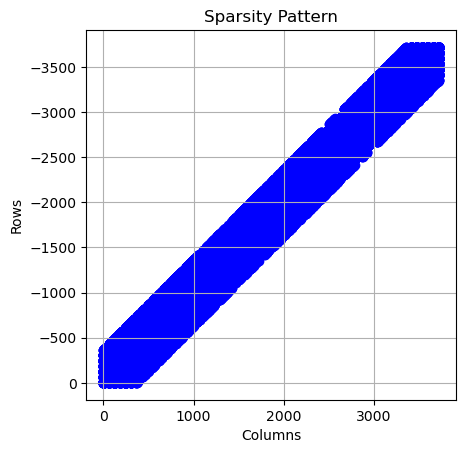

In [25]:
# inspect adjacency matrix
def edge_index_to_adjacency_matrix(edge_index, num_nodes):
    """Convert edge_index to an adjacency matrix."""
    adj_matrix = torch.zeros(num_nodes, num_nodes)
    adj_matrix[edge_index[0, :], edge_index[1, :]] = 1
    return adj_matrix

# Convert edge_index to adjacency matrix
adj_matrix = edge_index_to_adjacency_matrix(train_batch.edge_index, train_batch.x.shape[0])

# Plot adjacency matrix
x, y = np.where(adj_matrix == 1)
plt.scatter(y, -x, marker='o', color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()  # To match MATLAB's spy function's layout
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Sparsity Pattern')
plt.grid(True)
plt.show()

# Building the Model

## Graph Neural Operator

In [27]:

class KernelNN(torch.nn.Module):
    def __init__(self, width, ker_width, depth, ker_in, in_width=1, out_width=1):
        super(KernelNN, self).__init__()
        self.depth = depth

        self.fc1 = torch.nn.Linear(in_width, width)

        kernel = DenseNet([ker_in, ker_width, ker_width, width**2], torch.nn.ReLU)
        self.conv1 = NNConv_old(width, width, kernel, aggr='mean')

        self.fc2 = torch.nn.Linear(width, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.fc1(x)
        for k in range(self.depth):
            x = F.relu(self.conv1(x, edge_index, edge_attr))

        x = self.fc2(x)
        return x

## MeshGraphNet (MGN) class

In [14]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type (node_position is encoded in edge attributes)
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)


## Temporal MGN model

In [15]:
class TransferTempoMGN(torch.nn.Module):
    def __init__(self, mgn_model, hidden_dim, output_dim, args, emb=False):
        super(TransferTempoMGN, self).__init__()
        """
        input: mgn_model: a pretrained Meshgraphnet
        """
        # initialize FeatureExtractor class, which has a complete forward function and returns
        # the last layer of processor
        self.data_type = args.data_type
        self.num_layers = args.num_layers
        
        self.need_edge_weight = args.need_edge_weight
        #self.feature_extractor = mgn_model
        self.feature_extractor = nn.ModuleList(mgn_model.children())[:-1]
        
        if (args.pre_trained):
            self.decoder = nn.ModuleList(mgn_model.children())[-1]
            for param in mgn_model.parameters():
                param.requires_grad = False
        else:
            # Fine-tuned a decoder. certainly we can the pre-trained one too
            self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )
            
        # Stack a consLSTM model after the last layer of processor is finished
        self.lstm_filter_size = args.lstm_filter_size
        self.recurrent_model = GConvLSTM(hidden_dim, hidden_dim, self.lstm_filter_size)

    def build_processor_model(self):
        return ProcessorLayer

    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge, h_0, c_0):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors

        h_0: hidden state from previous timestep
        c_0: cell state from previous timestep
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.feature_extractor[0](x) # output shape is the specified hidden dimension
        edge_attr = self.feature_extractor[1](edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x, edge_attr = self.feature_extractor[2][i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest
        # step 3: feed the propagated node embeddings into convLSTM
        if (self.need_edge_weight):
            edge_weight = edge_attr
        else:
            edge_weight = torch.ones( edge_attr.shape[0] ).to(args.device)

        h_new, c_new = self.recurrent_model(x, edge_index, edge_weight, h_0, c_0)
        # step 4: decode latent node embeddings into physical quantities of interest 

        # step 5: return hidden state and cell state
        return self.decoder(h_new), h_new, c_new

    def loss(self, pred, inputs,mean_vec_y,std_vec_y, num):
        #Define the node types that we calculate loss for

        #Get the loss mask for the nodes of the types we calculate loss for
        #Need more delibrations
        if (self.data_type.upper() == 'HEXA'):
            well_loss_mask = (torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(0)) # extra weight (well)
            normal_loss_mask = (torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(1))
        
        if (self.data_type.upper() == 'PEBI'):
            well_loss_mask = (torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(1)) # extra weight (well)
            normal_loss_mask = (torch.argmax(inputs.x[:,3:],dim=1)!=torch.tensor(1))
            
        #Normalize labels with dataset statistics
        labels = normalize(inputs.y[:, num],mean_vec_y[num],std_vec_y[num]).unsqueeze(-1)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[normal_loss_mask])) + args.well_weight * torch.sqrt(torch.mean(error[well_loss_mask]))
        #loss=torch.sqrt(torch.mean(error))
        
        return loss

ProcessorLayer inherits from the PyG MessagePassing base class and handles processor/GNN part of the architecture. 👇

## ProcessorLayer Class: Edge Message Passing, Aggregation, and Updating


## Edge and Node MLP

In [16]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

# Training and Testing

## Train function

In [39]:
def train(train_loader, test_loader_list, device, args, PATH=None):
    '''
    Performs a training loop on the dataset for GNO. Also calls
    test functions.
    '''

    model = KernelNN(args.width,
                     args.ker_width,
                     args.depth,
                     args.edge_features,
                     args.node_features).to(device)
    epochs = args.epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.scheduler_step, gamma=args.scheduler_gamma)

    myloss = LpLoss(size_average=False)
    u_normalizer.cuda()

    losses = [] # training losses
    test_losses = [] # testing losses

    model.train()
    ttrain = np.zeros((epochs, ))
    ttest16 = np.zeros((epochs,))
    ttest31 = np.zeros((epochs,))
    ttest61 = np.zeros((epochs,))

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):

        train_mse = 0.0
        train_l2 = 0.0
        for batch in train_loader:
            batch = batch.to(device)

            optimizer.zero_grad()
            out = model(batch)
            mse = F.mse_loss(out.view(-1, 1), batch.y.view(-1,1))
            # mse.backward()
            loss = torch.norm(out.view(-1) - batch.y.view(-1),1)
            loss.backward()

            l2 = myloss(u_normalizer.decode(out.view(batch_size,-1)), u_normalizer.decode(batch.y.view(batch_size, -1)))
            # l2.backward()
            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        t2 = default_timer()
        model.eval()
        ttrain[epoch] = train_l2/(ntrain * k)
        print(' train_mse:', train_mse/len(train_loader))

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:

            test_loss, _ = test(test_loader, device, test_model, myloss, u_normalizer, test_num)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir(args.checkpoint_dir):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            df = df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': velo_val_losses[-1]}, ignore_index=True)
        else:
            df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))

            if(args.save_best_model):
                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )


In [21]:
def test(test_loader, device, test_model, myloss, u_normalizer, test_num):
  
    '''
    Performs a test loop on the dataset for GNO.
    Explain input arguments:
    test_loader: test dataset
    device: GPU or CPU
    test_model: trained model
    myloss: loss function
    u_normalizer: normalizer for output
    '''
    loss_test = 0.0

    with torch.no_grad():
        for batch in test_loader16:
            out = test_model(batch)
            loss_test += myloss(u_normalizer.decode(out.view(batch_size2,-1)),
                                batch.y.view(batch_size2, -1))
        # if velocity is evaluated, return velo_rmse as 0
    return loss_test/test_num

# Let's prepare the model for training!

Specify parameters for model training

Load the temporal dataset. Each batch contains all meshes at the same timestep

In [33]:
#dataset = extract_data(torch.load(file_path), [0], args.train_size+args.test_size)
 # train on 5 meshes with 30 timesteps ; test on 1 unseen mesh with 30 timesteps

train_mesh = [i for i in range(args.train_size)]

test_mesh = [i for i in range(args.train_size, 200)]
dataset_train = extract_PEBI_data(torch.load(file_path), train_mesh )
dataset_test = extract_PEBI_data(torch.load(file_path), test_mesh )

dataset = dataset_train + dataset_test 
args.train_size = len(dataset_train)
args.test_size = len(dataset_test)


print( 'Train size {}; Test size {}; total dataset size {}'.format(len(dataset_train), 
                                                                               len(dataset_test),
                                                                               len(dataset)))

print( 'Train batch size {}; Test batch size {}'.format( args.batch_size, 
                                                                               args.test_batch_size))


Train size 180; Test size 20; total dataset size 200
Train batch size 10; Test batch size 4


In [34]:
dataset_test

[Data(x=[1701, 7], edge_index=[2, 9752], edge_attr=[9752, 4], y=[1701, 20], mesh_pos=[1701, 3]),
 Data(x=[1756, 7], edge_index=[2, 10006], edge_attr=[10006, 4], y=[1756, 20], mesh_pos=[1756, 3]),
 Data(x=[1660, 7], edge_index=[2, 9588], edge_attr=[9588, 4], y=[1660, 20], mesh_pos=[1660, 3]),
 Data(x=[1726, 7], edge_index=[2, 9838], edge_attr=[9838, 4], y=[1726, 20], mesh_pos=[1726, 3]),
 Data(x=[1693, 7], edge_index=[2, 9584], edge_attr=[9584, 4], y=[1693, 20], mesh_pos=[1693, 3]),
 Data(x=[1670, 7], edge_index=[2, 9548], edge_attr=[9548, 4], y=[1670, 20], mesh_pos=[1670, 3]),
 Data(x=[1579, 7], edge_index=[2, 9098], edge_attr=[9098, 4], y=[1579, 20], mesh_pos=[1579, 3]),
 Data(x=[1672, 7], edge_index=[2, 9466], edge_attr=[9466, 4], y=[1672, 20], mesh_pos=[1672, 3]),
 Data(x=[1675, 7], edge_index=[2, 9532], edge_attr=[9532, 4], y=[1675, 20], mesh_pos=[1675, 3]),
 Data(x=[1646, 7], edge_index=[2, 9390], edge_attr=[9390, 4], y=[1646, 20], mesh_pos=[1646, 3]),
 Data(x=[1757, 7], edge_inde

Shuffle the dataset and get the statistics of the dataset

In [35]:
if(args.shuffle):
  random.shuffle(dataset)

stats_list = get_stats(dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cuda


In [36]:
stats_list

[tensor([0.0000e+00, 9.8612e-16, 4.2073e-01, 8.8126e-01, 5.9366e-04, 4.8480e-02,
         6.9664e-02]),
 tensor([1.0000e-08, 1.0000e-08, 9.3847e-02, 3.2348e-01, 2.4358e-02, 2.1478e-01,
         2.5458e-01]),
 tensor([  0.0000,   0.0000,   0.0000, 283.9071]),
 tensor([1.6595e+02, 3.3743e+02, 1.0000e-08, 2.4657e+02]),
 tensor([5.9244e-05, 2.8603e-02, 4.3403e-02, 5.6281e-02, 6.4963e-02, 7.3303e-02,
         7.9313e-02, 8.5379e-02, 8.9879e-02, 9.4547e-02, 9.8092e-02, 1.0182e-01,
         1.0473e-01, 1.0782e-01, 1.1025e-01, 1.1287e-01, 1.1494e-01, 1.1723e-01,
         1.1906e-01, 1.2109e-01]),
 tensor([0.0025, 0.0840, 0.1036, 0.1173, 0.1254, 0.1326, 0.1374, 0.1420, 0.1454,
         0.1487, 0.1512, 0.1537, 0.1557, 0.1578, 0.1594, 0.1611, 0.1625, 0.1639,
         0.1651, 0.1664])]

# Training

Start the training!

In [37]:
torch.cuda.empty_cache()

In [38]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader = train(dataset, device, 
                                                                                      stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

Training:   0%|          | 1/2000 [00:29<16:26:36, 29.61s/Epochs]

train loss 52.51 test loss 49.62 velo loss 0.11889


Training:   5%|▌         | 101/2000 [45:40<17:09:10, 32.52s/Epochs]

train loss 33.96 test loss 39.83 velo loss 0.08968


Training:  10%|█         | 201/2000 [1:32:41<13:32:35, 27.10s/Epochs]

train loss 9.39 test loss 9.52 velo loss 0.05193


Training:  15%|█▌        | 301/2000 [2:17:04<12:48:15, 27.13s/Epochs]

train loss 6.25 test loss 9.49 velo loss 0.05112


Training:  20%|██        | 401/2000 [3:01:24<12:03:05, 27.13s/Epochs]

train loss 4.54 test loss 9.18 velo loss 0.0503


Training:  25%|██▌       | 501/2000 [3:45:46<11:16:15, 27.07s/Epochs]

train loss 4.59 test loss 9.85 velo loss 0.05052


Training:  30%|███       | 601/2000 [4:30:05<10:30:18, 27.03s/Epochs]

train loss 3.41 test loss 8.64 velo loss 0.04806


Training:  35%|███▌      | 701/2000 [5:14:26<9:48:55, 27.20s/Epochs] 

train loss 3.12 test loss 8.87 velo loss 0.04741


Training:  40%|████      | 801/2000 [5:58:48<9:02:03, 27.13s/Epochs]

train loss 3.28 test loss 9.76 velo loss 0.04952


Training:  45%|████▌     | 901/2000 [6:43:09<8:16:23, 27.10s/Epochs]

train loss 2.94 test loss 8.84 velo loss 0.04814


Training:  50%|█████     | 1001/2000 [7:27:29<7:31:04, 27.09s/Epochs]

train loss 2.3 test loss 8.93 velo loss 0.04672


Training:  55%|█████▌    | 1101/2000 [8:11:50<6:46:20, 27.12s/Epochs]

train loss 1.92 test loss 9.04 velo loss 0.04752


Training:  60%|██████    | 1201/2000 [8:56:10<6:01:22, 27.14s/Epochs]

train loss 1.61 test loss 9.46 velo loss 0.04739


Training:  65%|██████▌   | 1301/2000 [9:40:48<5:18:39, 27.35s/Epochs]

train loss 1.91 test loss 8.91 velo loss 0.04786


Training:  70%|███████   | 1401/2000 [10:25:09<4:30:24, 27.09s/Epochs]

train loss 1.5 test loss 9.14 velo loss 0.04745


Training:  75%|███████▌  | 1501/2000 [11:09:30<3:44:44, 27.02s/Epochs]

train loss 1.68 test loss 8.98 velo loss 0.04591


Training:  80%|████████  | 1601/2000 [11:53:49<2:59:55, 27.06s/Epochs]

train loss 1.65 test loss 9.21 velo loss 0.04825


Training:  85%|████████▌ | 1701/2000 [12:38:08<2:14:51, 27.06s/Epochs]

train loss 1.38 test loss 8.87 velo loss 0.04656


Training:  90%|█████████ | 1801/2000 [13:22:27<1:29:57, 27.12s/Epochs]

train loss 1.52 test loss 9.02 velo loss 0.04711


Training:  95%|█████████▌| 1901/2000 [14:06:48<44:42, 27.09s/Epochs]  

train loss 1.52 test loss 8.9 velo loss 0.04687


Training: 100%|██████████| 2000/2000 [14:50:41<00:00, 26.72s/Epochs]

Min test set loss: 8.575910568237305
Minimum loss: 1.1801764013866582
Minimum velocity validation loss: 0.04585757479071617


Let's visualize the results!

In [40]:
def save_plots(args, losses, test_losses, velo_val_losses):
    
    #Define the model name for saving 
    model_name= args.model + '_data_'+ args.data_type + '_LSTM_k_' + str(args.lstm_filter_size )+ '_well_weight_' + str(args.well_weight) +\
                  '_norm'+ str(args.normalized)+ '_model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)
    
    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model)
    plt.plot(test_losses, label="test loss" + " - " + args.model)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

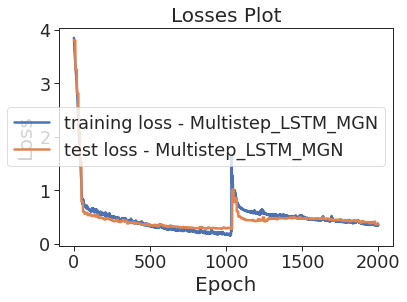

In [41]:
save_plots(args, losses, test_losses, velo_val_losses)

# Post-processing

In [136]:
from matplotlib import rc
import seaborn as sns 
import matplotlib as mpl

# set the plot style
def set_style():
    #plt.rc("font", family="Times New Roman")
    rc('mathtext', default='regular')
    sns.set_style('ticks')
    sns.set(style="ticks", rc={'axes.linewidth': 3.0, 'font.family': "sans-serif"})    
    sns.set_context("paper",font_scale = 2.0, rc={"font.size":20,
                                                  "axes.titlesize":20,
                                                  "axes.labelsize":20,
                                                  "lines.linewidth": 2.5})
     
set_style()
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

## Darcy's flow

With the methods below, we visualize the results from a model trained in this colab or a pre-trained model that we import from elsewhere.

## Visualization

In [ ]:


resolution = s
data = train_loader.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = u_normalizer.decode(data.y.reshape(1,-1)).numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_train + '.png')


resolution = 16
data = test_loader16.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test16 + '.png')

resolution = 31
data = test_loader31.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

# plt.figure()
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test31 + '.png')


resolution = 61
data = test_loader61.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

# plt.figure()
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test61 + '.png')